In [1]:
# 필요한 라이브러리 정리하기(이 셀에만 몰아서!)

import os.path
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import perf_counter

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [17]:
glob.glob("./finger_image/fimg/finger/*/*.jpg")

['./finger_image/fimg/finger\\five_finger\\five (1).jpg',
 './finger_image/fimg/finger\\five_finger\\five (10).jpg',
 './finger_image/fimg/finger\\five_finger\\five (100).jpg',
 './finger_image/fimg/finger\\five_finger\\five (101).jpg',
 './finger_image/fimg/finger\\five_finger\\five (102).jpg',
 './finger_image/fimg/finger\\five_finger\\five (103).jpg',
 './finger_image/fimg/finger\\five_finger\\five (104).jpg',
 './finger_image/fimg/finger\\five_finger\\five (105).jpg',
 './finger_image/fimg/finger\\five_finger\\five (106).jpg',
 './finger_image/fimg/finger\\five_finger\\five (107).jpg',
 './finger_image/fimg/finger\\five_finger\\five (108).jpg',
 './finger_image/fimg/finger\\five_finger\\five (109).jpg',
 './finger_image/fimg/finger\\five_finger\\five (11).jpg',
 './finger_image/fimg/finger\\five_finger\\five (110).jpg',
 './finger_image/fimg/finger\\five_finger\\five (111).jpg',
 './finger_image/fimg/finger\\five_finger\\five (112).jpg',
 './finger_image/fimg/finger\\five_finger\\f

In [3]:
# 이미지가 저장되어 있는 디렉토리 검색하고, 데이터프레임으로 저장하기

filepaths = glob.glob("./finger_image/fimg/finger/*/*") # 이미지 저장 경로 확인

def proc_img(filepath):

    labels = [str(filepath[i]).split("\\")[-2] for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head()

,Filepath,Label
0,./finger_image/fimg/finger\five_finger\five (1...,five_finger
1,./finger_image/fimg/finger\two_finger\two (451...,two_finger
2,./finger_image/fimg/finger\two_finger\two (379...,two_finger
3,./finger_image/fimg/finger\four_finger\four (3...,four_finger
4,./finger_image/fimg/finger\four_finger\four (4...,four_finger


In [4]:
# 이미지 개수 및 클래스 개수(종류 수) 확인하기

labels = df['Label'].values.tolist()

label_list=[]
for i in labels:
    if i not in label_list:
        label_list.append(i)

print('The number of pictures:', df.shape[0])
print('The number of labels:', len(label_list))
print('Labels:', label_list)
#print('The number of labels:', len(df.Label.unique()))
#print('Labels:', df.Label.unique())

The number of pictures: 2500
The number of labels: 5
Labels: ['five_finger', 'two_finger', 'four_finger', 'three_finger', 'one_finger']


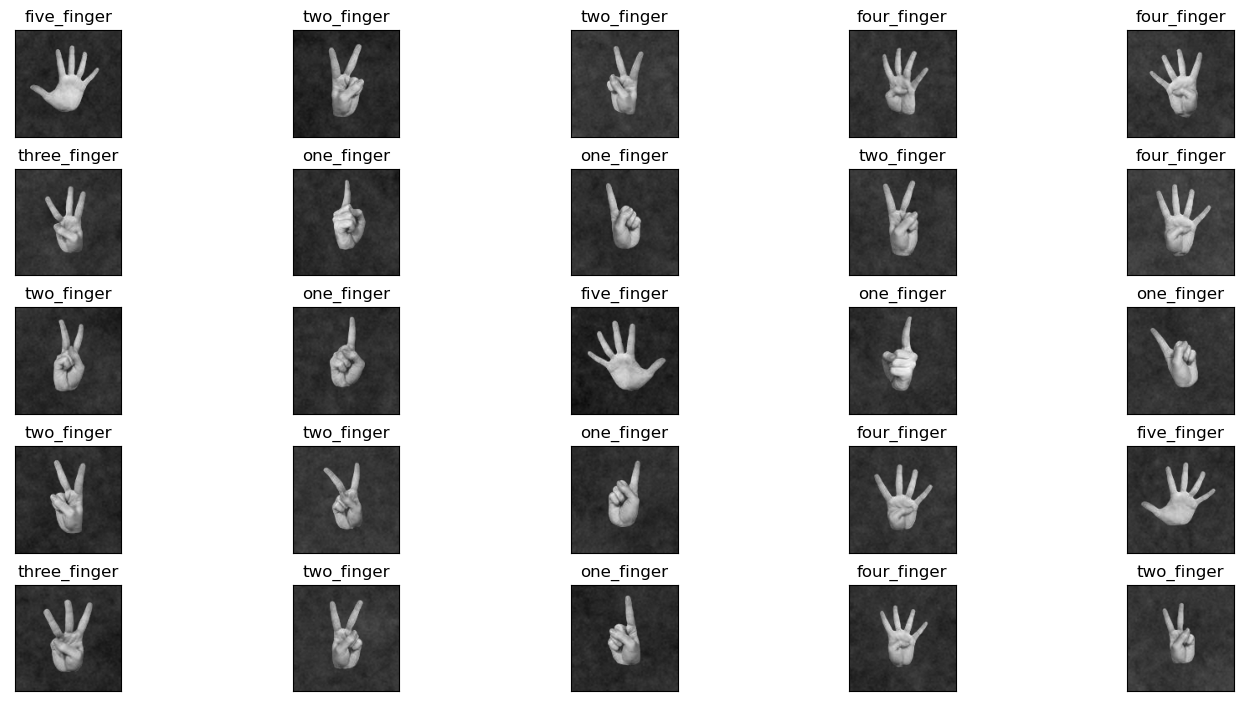

In [5]:
# 데이터 확인
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [6]:
# train, test set으로 split(9대 1)

train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((2250, 2), (250, 2))

In [7]:
# train_df를 9대 1로 split(train과 valid로)

train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=0)
train_df.shape, valid_df.shape

((2025, 2), (225, 2))

- Training size : 2025
- batch size : 75
- step_per_epoch : Training size/batch size이므로 27로 설정
- validation_step은 test_df의 사이즈가 225이므로 이를 75로 나눈 3으로 설정한다

In [8]:
# ImageDataGenerator 적용 과정(이미지 증강 과정)

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30, # 회전제한 각도 30도
                                   zoom_range=0.15, # 확대 축소 15%
                                   width_shift_range=0.2, # 좌우이동 20%
                                   height_shift_range=0.2, # 상하이동 20%
                                   shear_range=0.15, # 반시계방햐의 각도
                                   horizontal_flip=True, # 좌우 반전 True
                                   fill_mode="nearest")

valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    target_size=(128, 128),
                                                    batch_size=75,
                                                    class_mode='categorical'
                                                    )

validation_generator  = valid_datagen.flow_from_dataframe(valid_df,
                                                     x_col='Filepath',
                                                     y_col='Label',
                                                     target_size=(128, 128),
                                                     batch_size=75,
                                                     class_mode='categorical'
                                                     )

Found 2025 validated image filenames belonging to 5 classes.
Found 225 validated image filenames belonging to 5 classes.


In [9]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (75, 128, 128, 3)
배치 레이블 크기: (75, 5)


In [10]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(5, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [11]:
%%time

history = model.fit(train_generator,
                       steps_per_epoch = train_df.shape[0]//75,
                       epochs = 15,
                       validation_data = validation_generator,
                       validation_steps = test_df.shape[0]//75)

Epoch 1/15
27/27 [==============================] - 48s 2s/step - loss: 1.5448 - accuracy: 0.2790 - val_loss: 1.1302 - val_accuracy: 0.5822
Epoch 2/15
27/27 [==============================] - 46s 2s/step - loss: 1.0042 - accuracy: 0.5649 - val_loss: 0.2792 - val_accuracy: 0.9422
Epoch 3/15
27/27 [==============================] - 47s 2s/step - loss: 0.4989 - accuracy: 0.8094 - val_loss: 0.2244 - val_accuracy: 0.9333
Epoch 4/15
27/27 [==============================] - 46s 2s/step - loss: 0.3151 - accuracy: 0.8849 - val_loss: 0.0705 - val_accuracy: 0.9911
Epoch 5/15
27/27 [==============================] - 47s 2s/step - loss: 0.2203 - accuracy: 0.9240 - val_loss: 0.1256 - val_accuracy: 0.9644
Epoch 6/15
27/27 [==============================] - 49s 2s/step - loss: 0.1488 - accuracy: 0.9501 - val_loss: 0.0599 - val_accuracy: 0.9956
Epoch 7/15
27/27 [==============================] - 49s 2s/step - loss: 0.0832 - accuracy: 0.9719 - val_loss: 0.0936 - val_accuracy: 0.9867
Epoch 8/15
27/27 [==

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

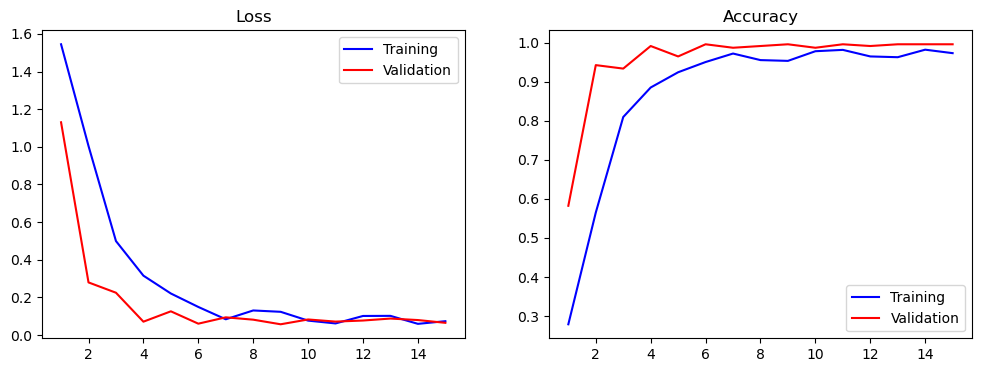

In [13]:
# 손실함수, 정확도 그래프 그리기

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss,'b', label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss,'r', label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc,'b', label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc,'r', label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 15)

In [14]:
# Test 데이터셋으로 성능 확인하기

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  x_col='Filepath',
                                                  y_col='Label',
                                                  target_size=(128, 128),
                                                  batch_size=75)

Found 250 validated image filenames belonging to 5 classes.


In [15]:
loss, accuracy = model.evaluate(test_generator)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

4/4 [==============================] - 2s 350ms/step - loss: 0.0011 - accuracy: 1.0000
Loss = 0.00111
Accuracy = 1.00000


In [16]:
model.save('cnn_test.h5')